In [54]:
import numpy as np
import math

In [58]:
#Hessian matrix needed for phi_ij term in lensing integral. Gravitational potential field is taken as input
def hessian(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x) 
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
    return hessian

def lensing_hessian(x):
  #assuming LOS is third diimension
  return hessian(x)[:2,:2,:,:,:]

In [56]:
#We start with the Point Mass:

#Defining the point mass, its distance from the image, and the box size
M = 10**6
Ds = 100
Dds = 200
bs = 50
G = 4.301*(10**(-9))

#Gravitational potential equation
potential = lambda x, y, z : - G * M / math.sqrt(x**2 + y**2 + (Ds - z)**2)

#Finding potential at all points 
points = np.empty((bs,bs,bs,3))
x1 = np.linspace(0,Dds,bs)
x2 = np.linspace(-Dds/2,Dds/2,bs)

for i in range(bs):
    for j in range(bs):
        for k in range(bs):
            points[i,j,k,:] = np.array([x2[i],x2[j],x1[k]])
            
potentials = np.empty((bs,bs,bs))

for i in range(bs):
    for j in range(bs):
        for k in range(bs):
            potentials[i,j,k] = potential(points[i,j,k,0],points[i,j,k,1],points[i,j,k,2])

#Finding hessian matrix
hessian = lensing_hessian(potentials)

#Determine geometry factors
geometry = lambda x: x*(1-(x/Dds))

geo = np.empty(bs)

for i in range(bs):
    geo[i] = geometry(x1[i])

#Integrate to find distortion matrix minus kronecker delta
psi = np.sum(2 * hessian * geo, axis=4)

#Check if code works
print(np.shape(psi))
print(psi[:,:,3,3])

(2, 2, 50, 50)
[[-3.81875936e-05 -1.43067576e-04]
 [-1.43067576e-04 -3.81875936e-05]]


Populating the interactive namespace from numpy and matplotlib


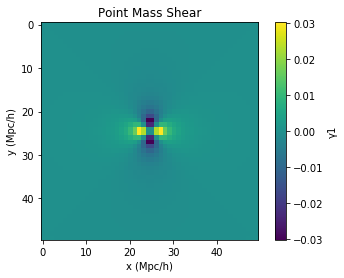

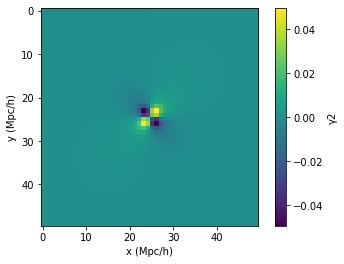

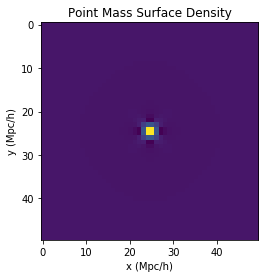

In [57]:
#Plot shear field and surface density field
%pylab inline

#Plot Gamma 1
imshow((-psi[1,1]+psi[0,0])/2)
xlabel('x (Mpc/h)')
ylabel('y (Mpc/h)')
title('Point Mass Shear')
colorbar().set_label('γ1')
show()

#Plot Gamma 2
imshow(psi[0,1])
xlabel('x (Mpc/h)')
ylabel('y (Mpc/h)')
colorbar().set_label('γ2')
show()

#Plot Surface Density
imshow((psi[1,1]+psi[0,0])/2)
xlabel('x (Mpc/h)')
ylabel('y (Mpc/h)')
title('Point Mass Surface Density')
show()

In [59]:
#RUN THE HESSIAN MATRIX FUNCTIONS ABOVE BEFORE RUNNING THIS CODE

#Example Cosmic Web Density Field
field = np.load("example_density.npy")

#Determine potential from density field by working in fourier space
def fftk(shape, symmetric=True, finite=False, dtype=np.float64):
    """
    Return k_vector given a shape (nc, nc, nc) and box_size
    """
    k = []
    for d in range(len(shape)):
        kd = np.fft.fftfreq(shape[d])
        kd *= 2 * np.pi
        kdshape = np.ones(len(shape), dtype='int')
        if symmetric and d == len(shape) -1:
            kd = kd[:shape[d]//2 + 1]
        kdshape[d] = len(kd)
        kd = kd.reshape(kdshape)
        k.append(kd.astype(dtype))
    del kd, kdshape
    return k

def laplace_kernel(kvec):
    """
    Compute the Laplace kernel from a given K vector
    Parameters:
    -----------
    kvec: array
        Array of k values in Fourier space
    Returns:
    --------
    wts: array
        Complex kernel
    """
    kk = sum(ki**2 for ki in kvec)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    wts = 1./kk
    imask = (~(kk==0)).astype(int)
    wts *= imask
    return wts

def density_to_potential(rho):
    """
    Computes the potential given a density field
    Parameters:
    -----------
    rho: array
        A 3D array of density values
    Returns:
    --------
    potential: array
        A 3D array of potential values, with no normalization applied.
    """    
    kvec = fftk(rho.shape)
    lk = laplace_kernel(kvec)
    ifield = np.fft.rfftn(rho)
    ifield *= lk
    field_l = np.fft.irfftn(ifield)
    return field_l

#Setting box size
bs_2 = 128
x3 =  np.linspace(0,Dds,bs_2)

#Calculate potential
potential_2 = density_to_potential(field)

#Find hessian matrix
hessian_2 = lensing_hessian(potential_2[0])

#Determine geometry terms
geometry_2 = lambda x: x*(1-x/Dds)
geo_2 = np.empty(bs_2)

for i in range(bs_2):
    geo_2[i] = geometry_2(x3[i])
    
#Integrate to find distortion matrix minus kronecker delta
psi_2 = np.sum(2 * hessian_2 * geo_2,axis=4)

#Check if code works
print(np.shape(psi_2))
print(psi_2[:,:,3,3])

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


(2, 2, 128, 128)
[[283.14626888 796.23177978]
 [796.23177978 834.81074545]]


Populating the interactive namespace from numpy and matplotlib


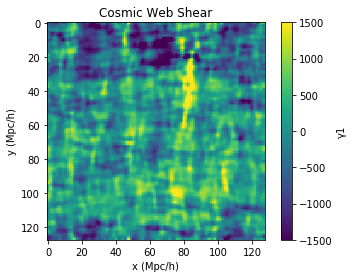

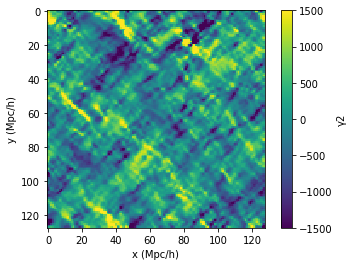

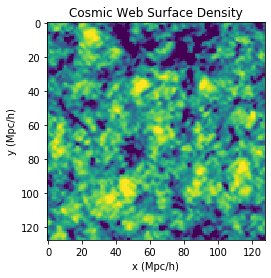

In [60]:
#Plot shear field and surface density field
%pylab inline

#Plot Gamma 1
imshow((-psi_2[1,1]+psi_2[0,0])/2,vmin=-1500,vmax=1500)
xlabel('x (Mpc/h)')
ylabel('y (Mpc/h)')
title('Cosmic Web Shear')
colorbar().set_label('γ1')
show()

#Plot Gamma 2
imshow(psi_2[0,1],vmin=-1500,vmax=1500)
xlabel('x (Mpc/h)')
ylabel('y (Mpc/h)')
colorbar().set_label('γ2')
show()

#Plot Surface Density
imshow((psi_2[1,1]+psi_2[0,0])/2,vmin=-1500,vmax=1500)
xlabel('x (Mpc/h)')
ylabel('y (Mpc/h)')
title('Cosmic Web Surface Density')
show()